# MATH60629
# Semaine \#6 (Partie I) - Recurrent Neural Networks - Exercices
Auteur: *Oleksiy Ostapenko*

(Créé à partir de: [Deep Learning Book](https://www.deeplearningbook.org/), [Christophe Olah's Blog](http://colah.github.io/), RNNs [tutorial](https://colab.research.google.com/drive/1jR_DGoVDcxZ104onxTk2C7YeV7vTt1DV#scrollTo=dRNYHWwYyd4Q) de Yen-Ling Kuo et Eugenio Piasini)

Nous allons explorer la modélisation de données séquentielles avec des réseaux récurrents (RNN). Nous commencerons par les étudier morceau par morceau pour gagner en intuition. 

Dans la seconde partie, nous les utiliserons pour modéliser des données textuelles. On pourra d'ailleurs faire le parallèle avec l'encodage sac à mots (bag of words) que nous avions vu il y a quelques semaines.

Les RNNs n'existent pas avec sklearn et nous utiliserons plutôt la librairie [Pytorch](https://colab.research.google.com/drive/1y9raF4S_HM3XU8e6es5j_l0WerKTQJeu#scrollTo=9OpW6mo6Nwgy&line=1&uniqifier=1). Il s'agit d'une libraire à code libre très puissante, pouvant notamment automatiquement calculer les gradients étant donné un modèle et très utilisée. Par contre, sa compréhension complète dépasse l'étendue du cours et nous l'utiliserons donc seulement pour pouvoir en apprendre plus sur les RNNs. 

# Première partie&nbsp;: apprendre la fonction sinus

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np
torch.manual_seed(2024)
np.random.seed(2024)

%matplotlib inline
import matplotlib.pyplot as plt

Générons pour commencer des données venant de la fonction sinus (`np.sin`).

In [31]:
def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len-1]
    ys = data[1:train_len] # comme discuté en cours, les cibles (y) sont décalées
                           # d'un pas de temps la tâche pourra donc être de prédire
                           # la valeur la fonction à t+1 
                           # étant donné ses valeurs au temps t=1,...,t

    train_x = torch.Tensor(xs).view(-1, 1, 1)
    train_y = torch.Tensor(ys)
    return data, time_steps, train_x, train_y

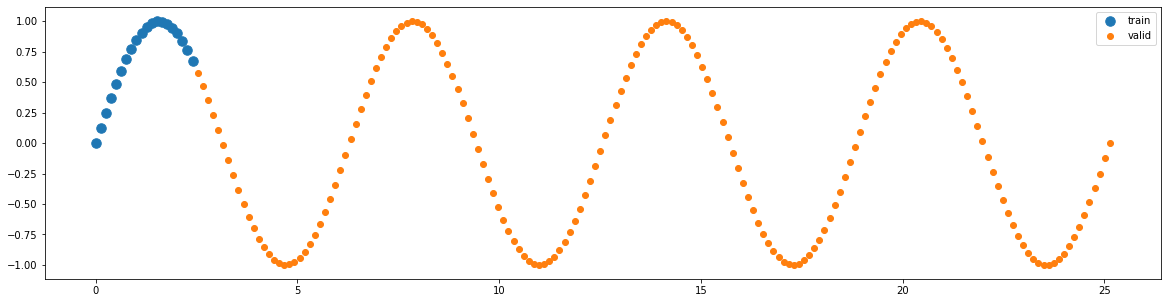

In [32]:
seq_length = 200 # longeur totale de la séquence
portion_train = 0.1 # proportion de la séquence utilisée pour l'entraînement

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = generate_sinus_wave(train_len=train_len, 
                                                         valid_len=valid_len)

# visualisons nos données
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

 Notre première tâche est de prédire la valeur de la série au pas de temps $t+1$ étant donnée la séquence des tous les points précédents (donc jusqu'à la donnée au temps $t$).

Visualisons nos données. Dans la première figure, on montre la tâche à accomplir: à partir de données jusqu'au temps $t$ (en vert) prédire la valeur de la série temporelle au temps $t+1$ (en rouge). 

En pratique, le RNN peut être entraîné en mode many-to-many (voir diapos), c'est-à-dire de prendre en entrée toute la série temporelle et de prédire à chaque pas de temps la valeur du pas de temps futur. En d'autres mots, x et y sont des vecteurs.

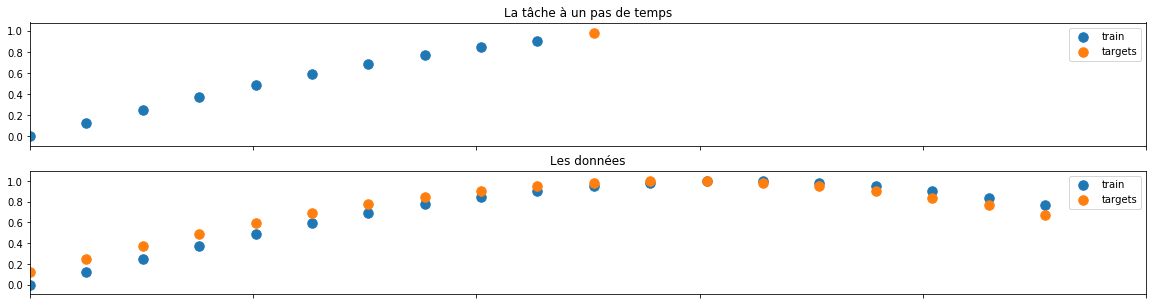

In [33]:
#plot our data
fig, ax = plt.subplots(2,figsize=(20,5))
ax[1].scatter(time_steps[:train_len-1], train_x, s=90,  label='train')
ax[1].scatter(time_steps[:train_len-1], train_y, s=90, label='targets')
ax[1].set_title('Les données')
ax[1].set_xlim([0,2.5])
ax[1].set_xticklabels([])
ax[1].legend()

ax[0].scatter(time_steps[:10], train_x[:10], s=90, label='train')
ax[0].scatter(time_steps[10], train_y[10], s=90, label='targets')
ax[0].set_title('La tâche à un pas de temps')
ax[0].set_xlim([0,2.5])
ax[0].set_xticklabels([])
ax[0].legend();

En plus de prédire la valeur suivante, nous allons aussi utiliser le RNN pour générer de nouveaux points qui vont au-delà de ce que le modèle a vu en entraînement. 

Avant de se lancer, voici un bref rappel des notions fondamentales des RNNs. 

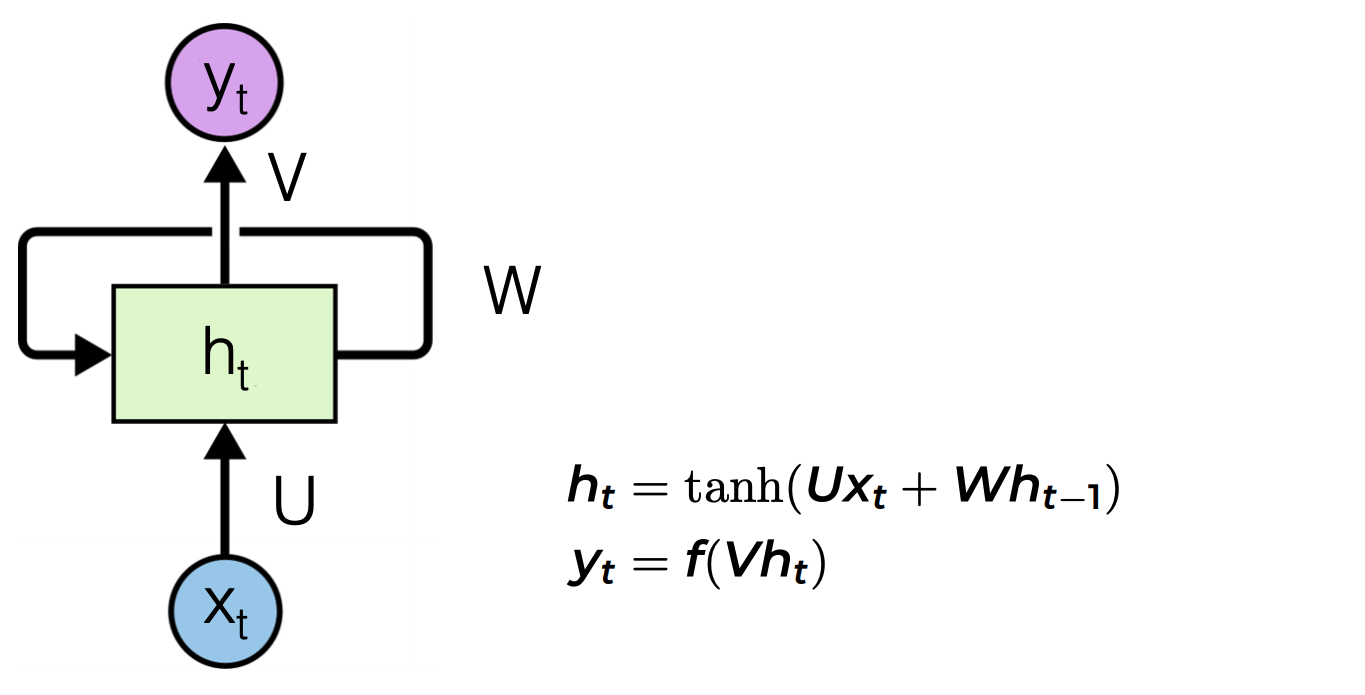
Source http://colah.github.io/

Comme nous l'avons vu en classe, la cellule d'un réseau récurrent (figure du haut) prend une entrée $X_t$ et produit une sortie $y_t$ ainsi qu'un état caché qui sera passé à travers une connexion récurrente au prochain pas de temps (dans la figurée du haut, les poids $W$ paramètrent la connexion récurrente)

Nous allons implémenter cette cellule RNN en utilisant Pytorch. Au lieu, d'utiliser la fonction d'activation $tanh$, nous utiliserons la sigmoïde puisqu'elle produit de meilleurs résultats pour notre problème (l'apprentissage profond est un champ très empirique).

*Remarque technique:* notez que la seconde équation dans la figure en haut ($y_t = f(Vh_t)$) ressemble beaucoup à celle que les neurones utilisent dans un réseau feed forward avec $V$ les paramètres à apprendre et $f$ la fonction d'activation. Pytorch nous offre déjà l'implémentation de cette fonction que nous garderons hors de la cellule du RNN. 

In [34]:
class RNN_Cell(nn.Module): 
    def __init__(self, input_size, hidden_size):
        super(RNN_Cell, self).__init__() # c'est ici que nous définissons la cellule du RNN
        self.input_size = input_size
        self.hidden_size = hidden_size

        # on initialise aléatoirement les paramètres à entraîner
        self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))

        self.b = torch.nn.Parameter(torch.randn(hidden_size))

    def forward(self, x_t, state): # la fonction forward implémente la logique

        # l'état devient l'état précédent
        h_prev = state

        # et puis nous transcrivons en Python les équations du haut
        #            U * X'.     +.         W * ht-1        + intercepte 
        a = torch.mm(x_t, self.U) + torch.mm(h_prev, self.W) + self.b
        #         sigmoide(a)
        h = torch.sigmoid(a)

        return h

Maintenant que nous avons le code pour une cellule, nous pouvons assembler les cellules ensemble pour obtenir le RNN. 

Rappelez-vous que dans un RNN la même cellule (c'est-à-dire avec les mêmes paramètres) est utilisée à chaque pas de temps pour transformer l'entrée $X_t$ et l'état précédent ($h_prev$) en un état suivant. 

Il ne faut pas oublier d'ajouter notre couche de sortie ($y_t = f(Vh_t)$). Nous allons utiliser une fonction d'activation $f$ d'identité puisque nos sorties prennent des valeurs réelles non bornées (on aurait aussi pu borner avec les valeurs extrêmes de la fonction sinus).

In [35]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn_cell = RNN_Cell(input_dim, hidden_size)
        # c'est ici que nous ajoutons la couche de sortie, 
        # qui utilise l'état caché
        self.linear = nn.Linear(hidden_size, 1) 
        
    def init_hidden(self,):
        return torch.zeros(1,self.hidden_size) # on initialise les états cachés à 0
    
    def forward(self, X, h=None): 
        # la logique du réseau
        
        # on veut permettre de passer un état précédent
        # ça sera utile quand on voudra générer des données
        # au-delà du prochain pas de temps.
        if h is None:
            self.h = self.init_hidden() 
        else:
            self.h = h
        outputs = []

        # pour chaque pas de temps dans notre séquence d'entrée
        for X_t in X:
            
            # on obtient l'état caché
            self.h = self.rnn_cell.forward(X_t, self.h)

            # on obtient une prédiction (many-to-many)
            y_t = self.linear.forward(self.h)
            
            # on garde toutes nos prédictions
            outputs.append(y_t)

        return torch.stack(outputs), self.h

**Question 1 (RNNs)** : Dans un modèle de réseau de neurones feed-forward, toutes les données sont modélisées comme étant indépendantes. Expliquer pourquoi ce n'est pas une hypothèse crédible pour les données séquentielles (par exemple les prix d'un titre à la bourse à travers le temps)?

<!-- In which line of code in the $forward$ function in the previous cell, do we explicitly break the assumption of data samples in the sequence being independent from each other?-->


**Question 2 (RNNs)**: Dans vos mots, expliquez le rôle de l'état caché ($h$) dans un RNN?


Maintenant que nous avons implémenté le modèle et notamment la façon dont les données sont acheminées vers les prédictions (`forward`), nous pouvons discuter de l'apprentissage (`backward`). 

La méthode pour entraîner les poids des RNNs est la rétropropagation (comme pour les réseaux feed-forward). Pour les RNNs on l'appel souvent [rétropropagation à travers le temps (en anglais)](https://en.wikipedia.org/wiki/Backpropagation_through_time) puisque les poids du réseau permettent de passer l'information d'un pas de temps au prochain. Encore une fois, ce n'est que la rétropropagation classique appliquée au RNNs. L'idée, comme d'habitude, est de répéter l'application de la règle de la dérivation en chaine&nbsp;: 

Avec $F = f(y), y = g(x)$, nous avons que $ \frac{dF}{dx} = \frac{dF}{dy} \frac{dy}{dx}  $ (avec $f$ et $g$ des fonctions différentiables).

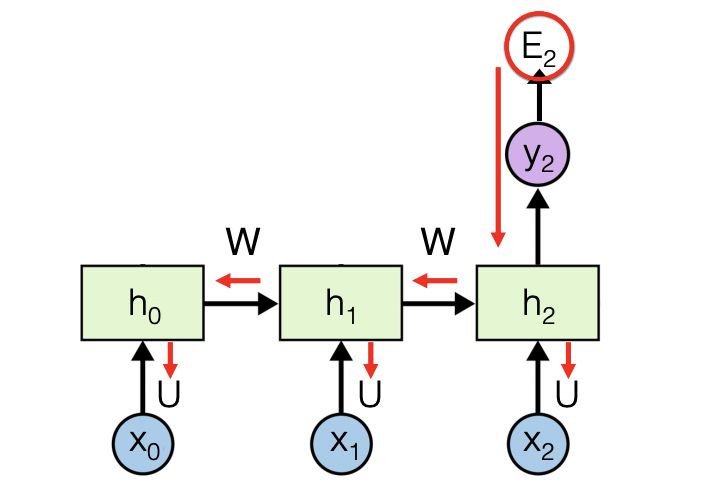
Source http://colah.github.io/

L'image plus haut montre un RNN pour des données de trois pas de temps. Pour illustrer la rétropropagation à travers le temps, nous pouvons utiliser quelques équations mathématiques. 

Pour simplifier l'exposition on ignore les fonctions d'activation, on suppose que les poids à apprendre $U$ et $W$ sont en fait des scalaires plutôt que des matrices et qu'il n'y a qu'une cible à prédire au dernier pas de temps (*many-to-one*).

$h_o = U x_0$

$h_1 = U x_1 + W h_0$ 

$h_2 = U x_2 + W h_1$ 

Imaginons que nous ayons affaire à un problème de régression, nous imaginons donc devoir minimiser l'erreur moyenne au carée&nbsp;:

$E = \frac{1}{2} (h_2 - y)^2 $, avec $y$ la valeur cible à prédire.

**Question 3 RNNs (Bonus)** : Écrivez les équations pour la rétropropagation à travers le temps pour les états $h_0$, $h_1$ et $h_2$ (indice: il suffit d'utiliser la règle de la dérivée en chaine à partir de l'objectif à optimiser.).


Heureusement, nous n'avons pas a coder les équations de la rétro-propagation puisque Pytorch s'en charge pour nous. 

Nous pouvons donc, simplement entraîner notre modèle avec les données que nous avons utilisées précédemment.

In [36]:
hidden_size = 10
learning_rate = 0.01


In [37]:
model = RNN(1,hidden_size) # on instancie notre model (un peu comme dans sklearn)

criterion = nn.MSELoss() # c'est de la régression et on utilisera donc
                         # une erreur moyenne au carré
# on va utiliser l'optimisateur adam (pour adaptive momentum estimation)
optimizer = optim.Adam(model.parameters(), learning_rate) 

epochs = 300 # une epoch correspond à un passer à travers toutes les 
             # données d'entraînement uue fois
for epoch in range(epochs):
    optimizer.zero_grad()
    
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.9153072834014893
Epoch 10: loss 0.057742565870285034
Epoch 20: loss 0.09892739355564117
Epoch 30: loss 0.04026682302355766
Epoch 40: loss 0.044826067984104156
Epoch 50: loss 0.034488581120967865
Epoch 60: loss 0.03226882219314575
Epoch 70: loss 0.02791777439415455
Epoch 80: loss 0.02395045943558216
Epoch 90: loss 0.019819926470518112
Epoch 100: loss 0.015079576522111893
Epoch 110: loss 0.00935346633195877
Epoch 120: loss 0.00576170114800334
Epoch 130: loss 0.004515610169619322
Epoch 140: loss 0.00402418989688158
Epoch 150: loss 0.0037884742487221956
Epoch 160: loss 0.0036477285902947187
Epoch 170: loss 0.0035232517402619123
Epoch 180: loss 0.00339338812045753
Epoch 190: loss 0.003260125173255801
Epoch 200: loss 0.003118521999567747
Epoch 210: loss 0.002950399648398161
Epoch 220: loss 0.0027070106007158756
Epoch 230: loss 0.002316146157681942
Epoch 240: loss 0.001870834268629551
Epoch 250: loss 0.0014890260063111782
Epoch 260: loss 0.0011142547009512782
Epoch 270: loss 0

Notre modèle est entraîné! 

Son erreur au carré semble bonne. 

Voyons aussi sa capacité à modéliser les données d'entraînement. Pour une donnée d'entraînement (au temps $t$), nous allons prédire une valeur cible (au temps $t+1$). On va garder l'état de l'état caché.

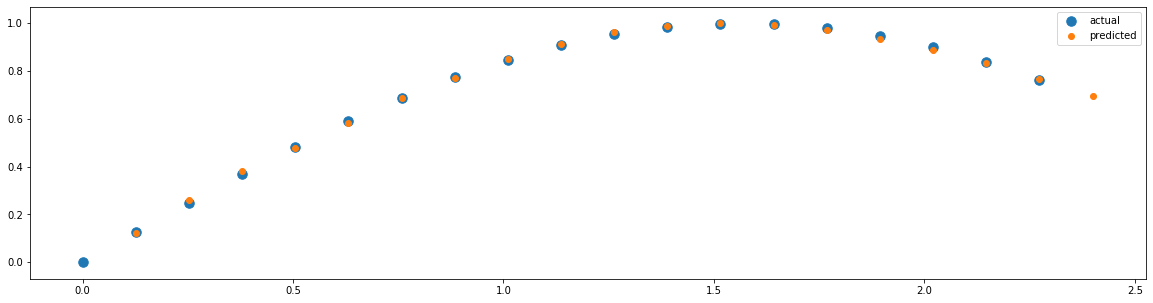

In [38]:
def make_predictions_train(model):
    predictions = []
    hidden_prev = None
    # pour chaque donnée dans notre ensemble d'entraînement
    for i in range(train_x.shape[0]):
        input = train_x[i]
        input = input.view(1, 1, 1)
      
        # nous obtenons: la prédiction et l'état caché
        # étant donnée: l'état caché précédent et la donnée
        pred, hidden_prev = model(input, hidden_prev)  

        # nous conservons les prédictions
        predictions.append(pred.data.numpy()[0][0])
    return predictions, hidden_prev

predictions_train, hidden_prev = make_predictions_train(model)

# voyons voir nos donnez et nos prédictions
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], data[:train_len-1], s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions_train, label='predicted')
ax.legend();

Comme l'erreur d'entraînement nous l'indiquait, on voit que notre modèle a appris a bien prédire les cibles de l'ensemble d'entraînement.

Qu'en est-il des données non observées? Nous avons écrit une courte fonction qui nous permet de générer des données (au-delà du temps $t+1$) à partir de notre modèle. Il nous suffit donc d'utiliser les prédictions à un temps $t$ comme les données au temps $t+1$. Avec cette procédure, nous pouvons générer autant de données que nous en voulons (paramètre `len` dans la fonction `generate_unseen_sequence`).

In [39]:
def generate_unseen_sequence(model, length, starting_point, hidden_state):
    predicts=[]
    input = torch.Tensor(starting_point).view(1,1,1)
    for i in range(length):
        pred, hidden_state = model(input, hidden_state)
        predicts.append(pred.data.numpy()[0][0])
        input = pred
    return predicts


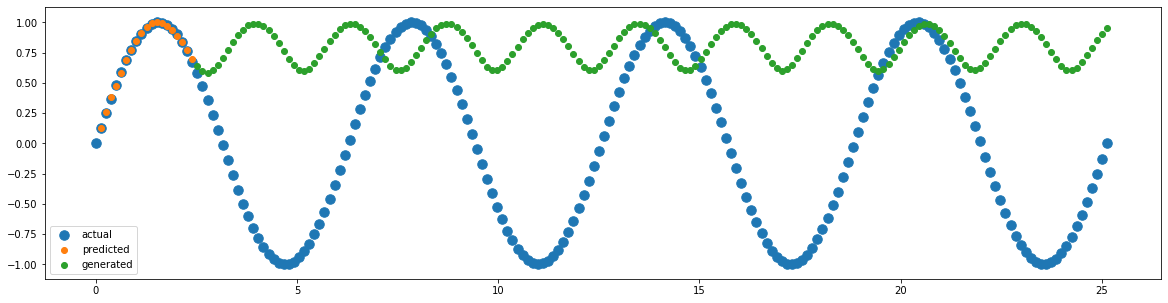

In [40]:
generated_points = generate_unseen_sequence(model, 
                                            valid_len, 
                                            starting_point=predictions_train[-1], 
                                            hidden_state=hidden_prev)

predictions = predictions_train+generated_points #concatenate two lists

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend();

Oups! Comme on le voit, notre modèle n'arrive pas à générer des données au-delà de données d'entraînement (prédictions en vert).

Comment expliquer ce résultat? Pensez-y avant de lire le prochain paragraphe. 

Nos données d'entraînement (en orange) ne contiennent qu'une petite partie de la fonction périodique. Difficile donc pour le modèle (ou même pour un humain) de généraliser au-delà. 

**Question 4 (RNNs)**: augmentez la taille de la séquence d'entraînement (variable $portion\_train$) dans le code ci-dessous. (Indice: essayez d'utiliser au moins une période complète de la fonction sinus.)

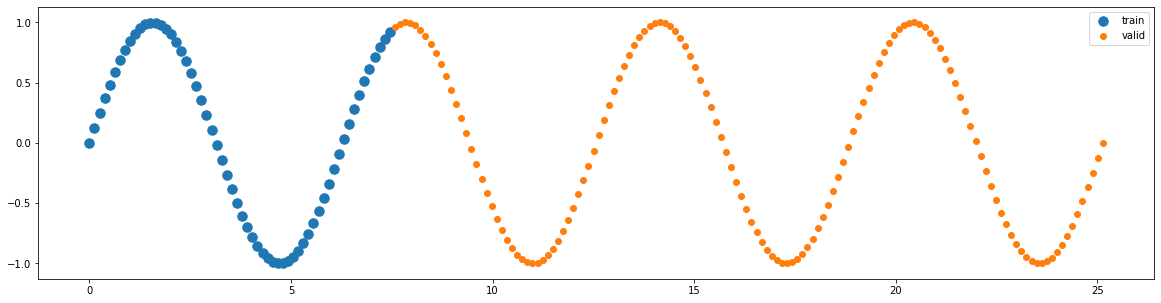

In [41]:
portion_train = 0.3 # À changer

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len

data, time_steps, train_x, train_y = \
     generate_sinus_wave(train_len = train_len, valid_len = valid_len)

fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

On peut réentrainer notre modèle et visualiser ses prédictions.

In [42]:
model = RNN(1,hidden_size)
optimizer = optim.Adam(model.parameters(), learning_rate)
epochs = 500 #
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.5011032819747925
Epoch 10: loss 0.2817439138889313
Epoch 20: loss 0.14002127945423126
Epoch 30: loss 0.04591163620352745
Epoch 40: loss 0.03437364846467972
Epoch 50: loss 0.01957571879029274
Epoch 60: loss 0.015781220048666
Epoch 70: loss 0.011615610681474209
Epoch 80: loss 0.009574673138558865
Epoch 90: loss 0.007917027920484543
Epoch 100: loss 0.006700703874230385
Epoch 110: loss 0.005720979534089565
Epoch 120: loss 0.0049013844691216946
Epoch 130: loss 0.004203831311315298
Epoch 140: loss 0.003591017099097371
Epoch 150: loss 0.0030460634734481573
Epoch 160: loss 0.00255316449329257
Epoch 170: loss 0.002111182315275073
Epoch 180: loss 0.0017363146180287004
Epoch 190: loss 0.001451345277018845
Epoch 200: loss 0.0012457752600312233
Epoch 210: loss 0.0010832187253981829
Epoch 220: loss 0.000947776366956532
Epoch 230: loss 0.0008383641252294183
Epoch 240: loss 0.0007509863353334367
Epoch 250: loss 0.000679797085467726
Epoch 260: loss 0.0006202259100973606
Epoch 270: loss 

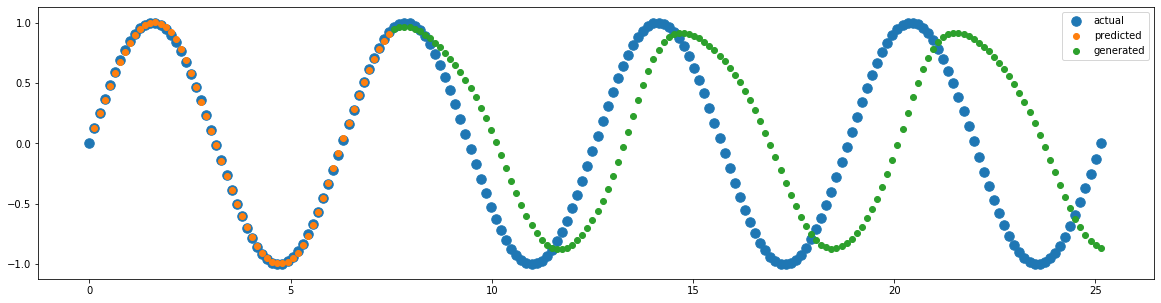

In [43]:
# on obtient les prédictions d'entraînement
predictions_train, hidden_prev = make_predictions_train(model)
# on génère des prédictions au-delà de l'ensemble d'entraînement
generated_points = generate_unseen_sequence(model, valid_len, 
                                            starting_point=predictions_train[-1], 
                                            hidden_state=hidden_prev)
# on visualise
predictions = predictions_train+generated_points 

fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

Et voilà notre modèle s’entraîne avec une partie plus significative d'une période capture beaucoup mieux la nature de la fonction sinus.

*Remarque:* à chaque réentraînement le modèle sera un peu différent. Ceci est dû à l'initialisation aléatoire des paramètres du réseau de neurones&nbsp;:

```
self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size)) 

self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
```


On pourrait sans doute obtenir des résultats encore meilleurs en:
- trouvant de meilleurs hyperparamètres 
- en allongeant encore la longueur des données d'entraînement

Ce sont des stratégies standards en apprentissage automatique et en apprentissage profond. Par contre, les performances peuvent aussi être améliorées en changeant le modèle. 

Notamment, dans le cas des RNN, on peut remplacer les cellules RNN par des cellules de LSTM. Comme discuté en classe, les cellules LSTM peuvent plus facilement retenir les dépendances entre données éloignées. Pour rappel, vous pouvez lire [cet article (en anglais)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) pour comprendre les détails des cellules LSTM par rapport aux cellules RNN.

In [44]:
class RNN_wLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNN_wLSTM, self).__init__()

        self.hidden_size = hidden_size

        ### Nouvelle cellule ###  
        # on utiliser l'implémentation disponible dans PyTorch 
        self.rnn_cell = nn.LSTMCell(input_dim, hidden_size)
        ################
        
        # on réutilise la même couche de sortie qu'avant 
        self.linear = nn.Linear(hidden_size, 1) 
        
    def init_hidden(self,):
        return (torch.zeros( 1, self.hidden_size),  torch.zeros( 1, self.hidden_size))
    
    def forward(self, X, h=None):
        self.h = self.init_hidden() if h is None else h
        outputs = []

        for X_t in X:
            self.h = self.rnn_cell(X_t, self.h)

            y_t = self.linear.forward(self.h[0])
            outputs.append(y_t)

        return torch.stack(outputs), self.h

In [45]:
model = RNN_wLSTM(1, hidden_size)
optimizer = optim.Adam(model.parameters(), 0.1)
epochs = 300
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.4571819305419922
Epoch 10: loss 0.020772308111190796
Epoch 20: loss 0.005182103719562292
Epoch 30: loss 0.001856080605648458
Epoch 40: loss 0.0006809868500567973
Epoch 50: loss 0.0002735429734457284
Epoch 60: loss 9.821399726206437e-05
Epoch 70: loss 4.0875394915929064e-05
Epoch 80: loss 3.450136864557862e-05
Epoch 90: loss 2.0560421035042964e-05
Epoch 100: loss 1.4013455256645102e-05
Epoch 110: loss 1.0518864655750804e-05
Epoch 120: loss 8.599669854447711e-06
Epoch 130: loss 7.29829025658546e-06
Epoch 140: loss 6.521847808471648e-06
Epoch 150: loss 5.980566129437648e-06
Epoch 160: loss 5.554980816668831e-06
Epoch 170: loss 5.199016868573381e-06
Epoch 180: loss 4.887396244157571e-06
Epoch 190: loss 4.608322342392057e-06
Epoch 200: loss 4.35503488915856e-06
Epoch 210: loss 4.1232451621908695e-06
Epoch 220: loss 3.9098895285860635e-06
Epoch 230: loss 3.7127504128875444e-06
Epoch 240: loss 3.5298367038194556e-06
Epoch 250: loss 3.359748916409444e-06
Epoch 260: loss 3.20117

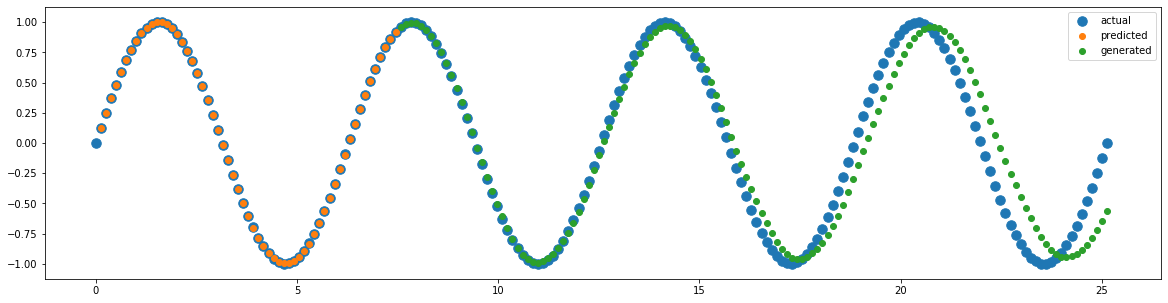

In [46]:
# on obtient les prédictions pour l'ensemble d'entraînement 
predictions_train, hidden_prev = make_predictions_train(model)
# on génère des données au-delà de l'entraînement 
generated_points = generate_unseen_sequence(model, valid_len, 
                                            starting_point=predictions_train[-1], 
                                            hidden_state=hidden_prev)
# on visualize
predictions = predictions_train+generated_points 

fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

Comme le montre la figure ci-haut, les LSTM capturent mieux la longueur des périodes ainsi que leur amplitude des données. De plus, ils sont souvent plus robustes à l'initialisation (et donne donc souvent d'aussi bons résultats, peu importe l'initialisation).

# Part 2: modélisation du langage



Nous allons maintenant étudier une tâche de modélisation du langage. Notamment, nous allons utiliser un RNN pour modéliser la tâche de prédiction de la prochaine lettre (caractère) dans une phrase. 

Nous nous sommes inspirés du tutoriel Yen-Ling Kuo and Eugenio Piasini qui est ici [(en anglais)](https://colab.research.google.com/drive/1jR_DGoVDcxZ104onxTk2C7YeV7vTt1DV#scrollTo=dRNYHWwYyd4Q)). Nous démarrons par télécharger des textes de Shakespeare.

In [47]:
input_file = 'input.txt'
!if [ ! -f $input_file ]; then wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt; fi

À partir des données initiales, nous écrivons une fonction qui pourra générer aléatoirement des séquences de mots qui nous serviront à entraîner notre réseau.

In [48]:
!pip3 install unidecode

import random
import unidecode

file = unidecode.unidecode(open('input.txt').read())

def random_chunk(chunk_len=200):
    start_index = random.randint(0, len(file) - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]
  

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


Voyons voir quelques phrases de notre ensemble d'entraînement.

In [49]:
print(random_chunk())

tisfy me.

GLOUCESTER:

CLARENCE:

GLOUCESTER:

KING EDWARD IV:
How many children hast thou, widow? tell me.

CLARENCE:

GLOUCESTER:

LADY GREY:
Three, my most gracious lord.

GLOUCESTER:

KING EDWARD 


Nous allons ensuite convertir chaque caractère en un index numérique. Les caractères sont des variables catégorielles et donc nous utiliserons une représentation one-of-K pour les encoder. 

Nous allons aussi écrire une fonction qui nous permettra d'obtenir des séquences d'entraînements. 

Pour notre RNN, l'entrée à chaque pas de temps est le caractère à la position $t$. Le modèle devra prédire le caractère suivant (celui à la position $t+1$).

In [50]:
import string

# Turn string into list of longs
def char_tensor(str, print_=False):
    tensor = torch.zeros(len(str), 1).long()
    for c in range(len(str)):
        tensor[c][0] = string.printable.index(str[c])
        if print_:
          print(f"Character: {str[c]} gets index {tensor[c][0]}")
    return tensor

char_tensor('Hello, how are you?', print_=True)

def random_train_data():    
    chunk = random_chunk()
    input = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return input, target

Character: H gets index 43
Character: e gets index 14
Character: l gets index 21
Character: l gets index 21
Character: o gets index 24
Character: , gets index 73
Character:   gets index 94
Character: h gets index 17
Character: o gets index 24
Character: w gets index 32
Character:   gets index 94
Character: a gets index 10
Character: r gets index 27
Character: e gets index 14
Character:   gets index 94
Character: y gets index 34
Character: o gets index 24
Character: u gets index 30
Character: ? gets index 82


Maintenant, on peut mettre en place notre modèle.

Ce modèle ressemblera beaucoup à celui que nous avons élaboré pour modéliser la courbe sinus. Nous y ajouterons, en plus, une couche d'entrée pour transformer le caractère (encodage one-of-K) dans un vecteur dense. Il y a donc trois couches en tout:
1. cette couche d'entrée, 
2. la couche récurrente 
3. la couche de sortie 

De plus, nous utiliserons un troisième type de cellule, un [GRU (en anglais)](https://en.wikipedia.org/wiki/Gated_recurrent_unit) pour la couche récurrente, c'est une variation similaire à la cellule LSTM. 

La couche de sortie sera simplement une couche linéaire suivie de la fonction softmax pour prédire la catégorie du caractère au temps $t+1$ (chaque caractère appartient à sa propre catégorie). La softmax est définie ainsi pour chaque élément $x_i$ d'un vecteur $x$: 

$$ \text{softmax}(x_i) = \frac{e^{x_i}}{\sum_j {e^{x_j}}} \;\;\;\text{pour } \forall i $$

Vous pouvez considérer la sortie d'un softmax comme étant une distribution sur les caractères. 

In [51]:
class ShakespeareRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(ShakespeareRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.embeding_size = 6
        
        self.embedding = nn.Embedding(len(string.printable), self.embeding_size) 
        self.rnn = nn.GRU(self.embeding_size, hidden_size, num_layers=n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def init_hidden(self):
         return torch.zeros(self.n_layers, 1, self.hidden_size)
    
    def forward(self, input, hidden):
        x = self.embedding(input)
        x, hidden = self.rnn(x.view(1,1,x.size(-1)), hidden)
        output = self.decoder(x)
        tag_scores = F.log_softmax(output[-1], dim=1)
        return output, hidden

In [52]:
def evaluate(model, prime_str='A', predict_len=100):
    hidden = model.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    input = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(input, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = string.printable[top_i]
        predicted += predicted_char
        input = char_tensor(predicted_char)

    return predicted

Nous pouvons maintenant entraîner notre modèle! 

*Note:* l'entraînement du modèle peut prendre plusieurs minutes. Vous verrez apparaître à intervalles réguliers des caractères générés par le modèle. Vous pouvez noter que la structure devient plus intelligible au fur et à mesure de l'entraînement.

In [53]:
n_characters = len(string.printable)
hidden_size = 100
n_layers = 2

epochs = 2000
lr = 0.005

model = ShakespeareRNN(n_characters, hidden_size, n_characters, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    loss = 0
    input, target = random_train_data()
    chunk_len = len(input)
    hidden = model.init_hidden()

    model.zero_grad()
    for x,y in zip(input, target):
      out, hidden = model(x, hidden)
      loss += criterion(out[-1], y)
    
    loss.backward()
    optimizer.step()

    loss = loss.item() / chunk_len
    if epoch % 100 == 0:
        print('[(%d %d%%) %.4f]' % (epoch, epoch / epochs * 100, loss))
        print(evaluate(model, 'Wh', 100), '\n')

[(0 0%) 4.5795]
Wh&\9E/X|^ps8J4<nRiYpjtls2<{XMCm)Dm^:DN.y|gr\z#'\56tse_>&g$n-/z{35}lJ75Iqiu!]O2AxBTC4FY&l0Io=, \0?l# 

[(100 5%) 3.4679]
WhanO
she
IroaDdchf as
lGsuIluce.RiiDI
se lanry;thee
rr,r thoshrheTsn

sdrfUmeF
I
d of rwvtt
o
OPfiier 

[(200 10%) 2.6832]
Wholuthot foud doliy tCen nohityCiAA adoraPe monKnt giper hin ess mod b iad why miPMe uuus.
tel, wou h 

[(300 15%) 2.3004]
Whhe disd are
P kes, id,

CEO:
dhe ir

MerRY sOO
AN:::
ToveKy thaand,.
XRl, low- cimnole,!
:R id shiI  

[(400 20%) 2.3101]
Where' filgang tued ct
mank the yrhus yuf hisr brin  canth foued sousb af raaind thas I gowstanbut ere 

[(500 25%) 2.4142]
Whistiy briesorald harkt-
Ar srake,
In nheacher same tinteels,
AY I anfutice: diy cingt,
Coom matter-b 

[(600 30%) 2.3981]
When, bouwstsess wast preveand tigh eill.

LANENUSEEE:
Rear to fo meved. I dimoust to wiet is amggavat 

[(700 35%) 2.2122]
Whlome? I ot chy,
If ulhsey. Rame. I geild dey forpe won'd my of heald, boofk wuuthel,
Ondell thiy whs 

[(800 40%) 2

On peut aussi demander au modèle de compléter une séquence de départ:

In [54]:
print(evaluate(model, 'Wh', predict_len=100), '\n')

Whemufew have thou;
lowit: eprernorge my newe to hereach life.
Sows our four it windile blall's a give 



In [55]:
print(evaluate(model, 'How', predict_len=100), '\n')

Howry remy'd hour untres thoue,
I larno yay, tell:
Of your will queey, lie; for purove ough noblous,
No 



In [56]:
print(evaluate(model, 'JULIET', predict_len=100), '\n')

JULIET SINCAND III
Sord are maiy what bumper'd them my wercomeswy.

RAMINIOLUS VINGTHIIUS:
sogle lisinlurg 

